#### <span style="color:#668B8B">Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:</span>

- #### <span style="color:#668B8B"> В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.</span>
- #### <span style="color:#668B8B"> Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.</span>

## <span style="color:#668B8B">Подключаем все необходимые библиотеки</span>

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import requests 
from urllib.parse import urlencode
import scipy.stats as ss
from scipy.stats import chi2_contingency
from tqdm.auto import tqdm
from scipy.stats import norm
%matplotlib inline

## <span style="color:#36648B"> Произведем загрузку данных в ДФ</span>

In [2]:
reg_data=pd.read_csv("~//shared/problem1-reg_data.csv", sep=';')

In [3]:
auth_data=pd.read_csv("~//shared/problem1-auth_data.csv", sep=';')

## <span style="color:#36648B">Посмотрим на данные из таблиц (тип данных, колличество записей и т.д.)</span>

In [4]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
reg_data.dtypes 

reg_ts    int64
uid       int64
dtype: object

In [6]:
reg_data.shape

(1000000, 2)

In [7]:
reg_data.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

In [8]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [9]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [10]:
reg_data.shape

(1000000, 2)

In [11]:
reg_data.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

## <span style="color:##668B8B">Подготовим данные для анализа</span>
## <span style="color:#36648B">Соединим таблицу "reg_data.csv" с данными таблици о времени захода пользователей в игру "auth_data.csv", так же приведем столбци reg_ts и auth_ts в нормальный читабельный вид</span>

In [12]:
reg_data['reg_ts']=pd.to_datetime(reg_data.reg_ts, unit='s').dt.date

In [13]:
reg_data=reg_data.drop_duplicates()
reg_data.head()

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5


In [14]:
auth_data['auth_ts']=pd.to_datetime(auth_data.auth_ts, unit='s').dt.date

In [15]:
auth_data=auth_data.drop_duplicates()
auth_data.head()

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2


In [16]:
data=reg_data.merge(auth_data, on ='uid', how = 'left')

In [17]:
data.columns

Index(['reg_ts', 'uid', 'auth_ts'], dtype='object')

In [18]:
data=data[['uid','reg_ts','auth_ts']]

In [19]:
data.head()

,uid,reg_ts,auth_ts
0,1,1998-11-18,1998-11-18
1,2,1999-07-22,1999-07-22
2,2,1999-07-22,1999-07-25
3,2,1999-07-22,1999-07-31
4,2,1999-07-22,1999-08-05


In [20]:
data.dtypes

uid         int64
reg_ts     object
auth_ts    object
dtype: object

In [21]:
data.dtypes

uid         int64
reg_ts     object
auth_ts    object
dtype: object

In [22]:
data['days_reg_platform']=(data.auth_ts-data.reg_ts).dt.days

In [23]:
data.head()

,uid,reg_ts,auth_ts,days_reg_platform
0,1,1998-11-18,1998-11-18,0
1,2,1999-07-22,1999-07-22,0
2,2,1999-07-22,1999-07-25,3
3,2,1999-07-22,1999-07-31,9
4,2,1999-07-22,1999-08-05,14


## <span style="color:#36648B">Посмотрим самую раннюю и самую позднюю дату регистрации пользователя</span>

In [24]:
data.min()

uid                           1
reg_ts               1998-11-18
auth_ts              1998-11-18
days_reg_platform             0
dtype: object

In [25]:
data.max()

uid                     1110622
reg_ts               2020-09-23
auth_ts              2020-09-23
days_reg_platform          7729
dtype: object

## <span style="color:#36648B">формируем когорту между днем регистрации и заходом колличества пользователей на платформу</span>

In [26]:
data_kogort1=data.groupby(['reg_ts','days_reg_platform'], as_index=False).agg({'uid':'nunique'})\
                                                             .rename(columns={'uid':'kogort_1'})
data_kogort1

,reg_ts,days_reg_platform,kogort_1
0,1998-11-18,0,1
1,1999-07-22,0,1
2,1999-07-22,3,1
3,1999-07-22,9,1
4,1999-07-22,14,1
...,...,...,...
2716223,2020-09-21,1,31
2716224,2020-09-21,2,49
2716225,2020-09-22,0,1641
2716226,2020-09-22,1,14


In [27]:
data_kogort2=data.query("days_reg_platform=='0'").groupby('reg_ts', as_index=False).agg({'uid':'nunique'}).rename(columns={'uid':'kogort_2'})
data_kogort2

,reg_ts,kogort_2
0,1998-11-18,1
1,1999-07-22,1
2,2000-01-13,1
3,2000-05-28,1
4,2000-09-16,1
...,...,...
5105,2020-09-19,1634
5106,2020-09-20,1636
5107,2020-09-21,1638
5108,2020-09-22,1641


In [28]:
data_retention=data_kogort2.merge(data_kogort1, on ='reg_ts')

In [29]:
data_retention=data_retention[['reg_ts','days_reg_platform','kogort_1','kogort_2']]

In [30]:
data_retention['retention']=round(data_retention.kogort_1/data_retention.kogort_2*100, 2)

In [31]:
data_retention

,reg_ts,days_reg_platform,kogort_1,kogort_2,retention
0,1998-11-18,0,1,1,100.00
1,1999-07-22,0,1,1,100.00
2,1999-07-22,3,1,1,100.00
3,1999-07-22,9,1,1,100.00
4,1999-07-22,14,1,1,100.00
...,...,...,...,...,...
2716223,2020-09-21,1,31,1638,1.89
2716224,2020-09-21,2,49,1638,2.99
2716225,2020-09-22,0,1641,1641,100.00
2716226,2020-09-22,1,14,1641,0.85


In [32]:
data_retention['reg_ts']=pd.to_datetime(data_retention['reg_ts'])

## <span style="color:#36648B">Данные представлены за очень большой промежуток времени поэтому ограничим промежуток времени 30-ю днями</span>

In [33]:
data_retention = data_retention.query("reg_ts >= '2020-09-01' and reg_ts < '2020-09-30'")

In [34]:
pivot1=data_retention.pivot_table(index = 'reg_ts', columns = 'days_reg_platform', values = 'retention').fillna('0')
pivot1

days_reg_platform,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
reg_ts,,,,,,,,,,,,,,,,,,,,,
2020-09-01,100.0,2.02,4.1,4.22,4.6,6.43,5.61,6.43,4.1,5.42,...,5.49,4.29,4.41,4.35,5.04,4.16,4.35,3.59,4.35,1.58
2020-09-02,100.0,2.52,3.9,4.66,5.67,6.23,7.12,6.3,4.85,4.09,...,4.35,4.97,5.29,4.16,4.85,3.9,3.72,4.66,2.64,0
2020-09-03,100.0,2.33,5.41,4.71,6.54,6.98,8.55,6.35,5.47,6.29,...,5.97,5.47,5.34,4.4,4.84,4.65,5.47,2.39,0,0
2020-09-04,100.0,2.01,3.64,3.64,5.15,6.4,7.28,4.96,5.34,4.33,...,5.59,4.39,4.52,4.52,4.27,4.77,2.64,0,0,0
2020-09-05,100.0,2.76,3.95,4.64,5.45,5.89,7.46,4.89,5.08,5.45,...,5.39,4.51,5.14,4.45,4.76,2.51,0,0,0,0
2020-09-06,100.0,3.13,4.32,5.44,5.63,5.88,6.82,6.07,5.82,5.5,...,5.19,5.5,4.57,4.82,2.56,0,0,0,0,0
2020-09-07,100.0,2.94,4.25,5.37,5.06,6.37,7.31,5.25,4.12,5.62,...,5.06,4.25,5.06,3.37,0,0,0,0,0,0
2020-09-08,100.0,1.75,3.93,3.93,4.86,7.61,7.54,6.61,5.17,5.17,...,5.17,4.74,3.05,0,0,0,0,0,0,0
2020-09-09,100.0,1.74,3.24,4.67,5.72,6.66,5.72,5.91,4.36,5.04,...,4.85,2.43,0,0,0,0,0,0,0,0


In [35]:
pivot1=pivot1.astype(float)

Text(0.5, 1.0, 'Retention, %')

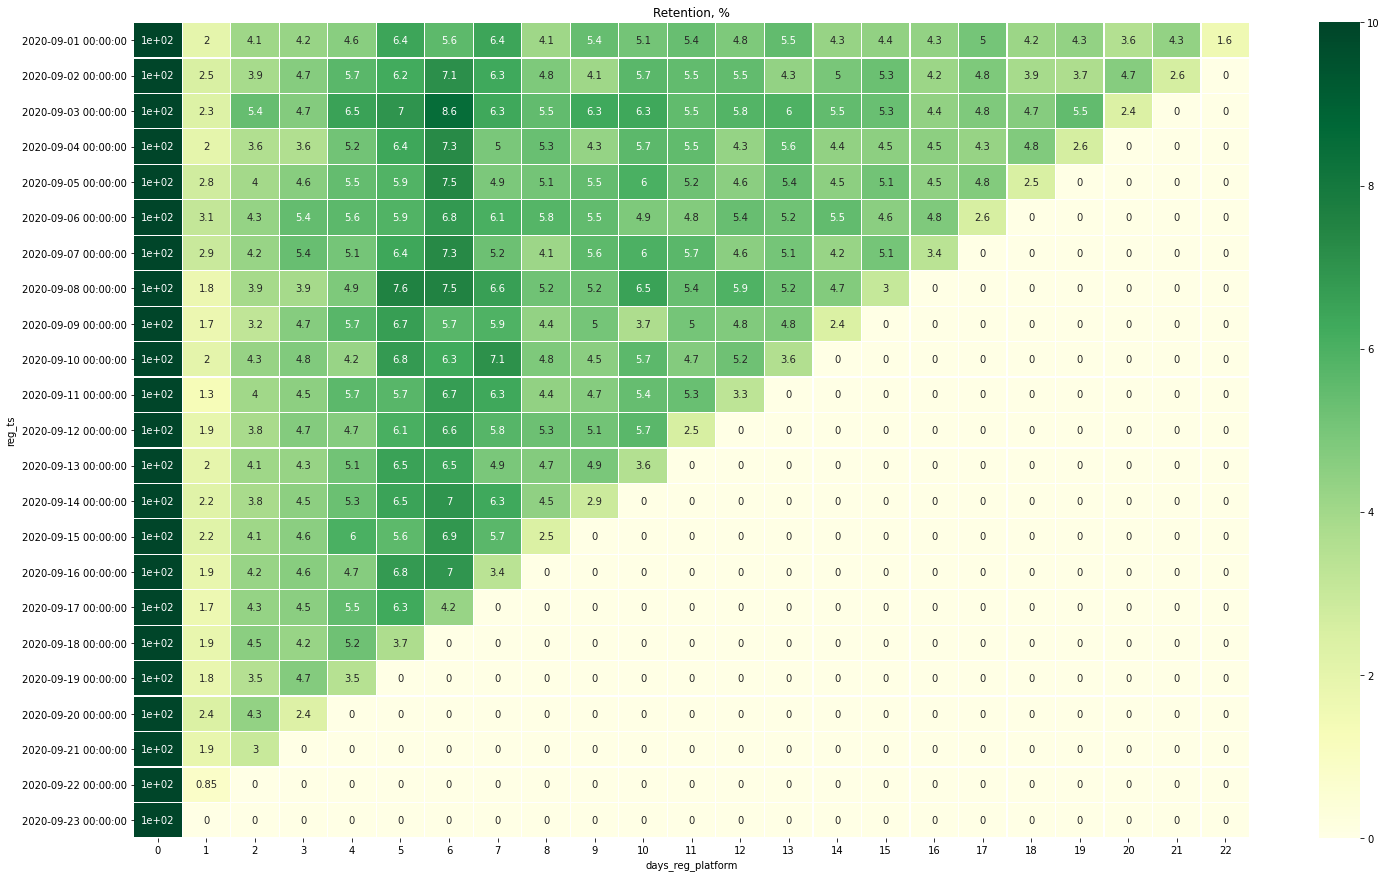

In [36]:
plt.figure(figsize=(25,15))
ax = sns.heatmap(data = pivot1, annot=True, vmin=0, linewidths=0.2, vmax=10,cmap='YlGn')
ax.set_yticklabels(pivot1.index)
plt.title('Retention, %')

## <span style="color:#668B8B"> Задание 1</span>

## <span style="color:#668B8B"> Разработаем функцию для расчета retention игроков</span>

In [37]:
def retention(reg_data, auth_data):
    reg_data=pd.read_csv("~//shared/problem1-reg_data.csv", sep=';')
    auth_data=pd.read_csv("~//shared/problem1-auth_data.csv", sep=';')
    reg_data['reg_ts']=pd.to_datetime(reg_data.reg_ts, unit='s').dt.date
    reg_data=reg_data.drop_duplicates()
    auth_data['auth_ts']=pd.to_datetime(auth_data.auth_ts, unit='s').dt.date
    auth_data=auth_data.drop_duplicates()
    data=reg_data.merge(auth_data, on ='uid', how = 'left')
    data=data[['uid','reg_ts','auth_ts']]
    data['days_reg_platform']=(data.auth_ts-data.reg_ts).dt.days
    data_kogort1=data.groupby(['reg_ts','days_reg_platform'], as_index=False).agg({'uid':'nunique'})\
                                                             .rename(columns={'uid':'kogort_1'})
    data_kogort2=data.query("days_reg_platform=='0'").groupby('reg_ts', as_index=False).agg({'uid':'nunique'})\
                                                             .rename(columns={'uid':'kogort_2'})
    data_retention=data_kogort2.merge(data_kogort1, on ='reg_ts')
    data_retention=data_retention[['reg_ts','days_reg_platform','kogort_1','kogort_2']]
    data_retention['retention']=round(data_retention.kogort_1/data_retention.kogort_2*100, 2)
    data_retention['reg_ts']=pd.to_datetime(data_retention['reg_ts'])
    data_retention = data_retention.query("reg_ts >= '2020-09-01' and reg_ts < '2020-09-30'")
    pivot1=data_retention.pivot_table(index = 'reg_ts', columns = 'days_reg_platform', values = 'retention').fillna('0')
    pivot1=pivot1.astype(float)
    plt.figure(figsize=(25,15))
    ax = sns.heatmap(data = pivot1,annot=True, vmin=0, linewidths=0.2, vmax=10,cmap='YlGn')
    ax.set_yticklabels(pivot1.index)
    plt.title('Retention, %')

## <span style="color:#668B8B"> Проведем тестирование функции</span>

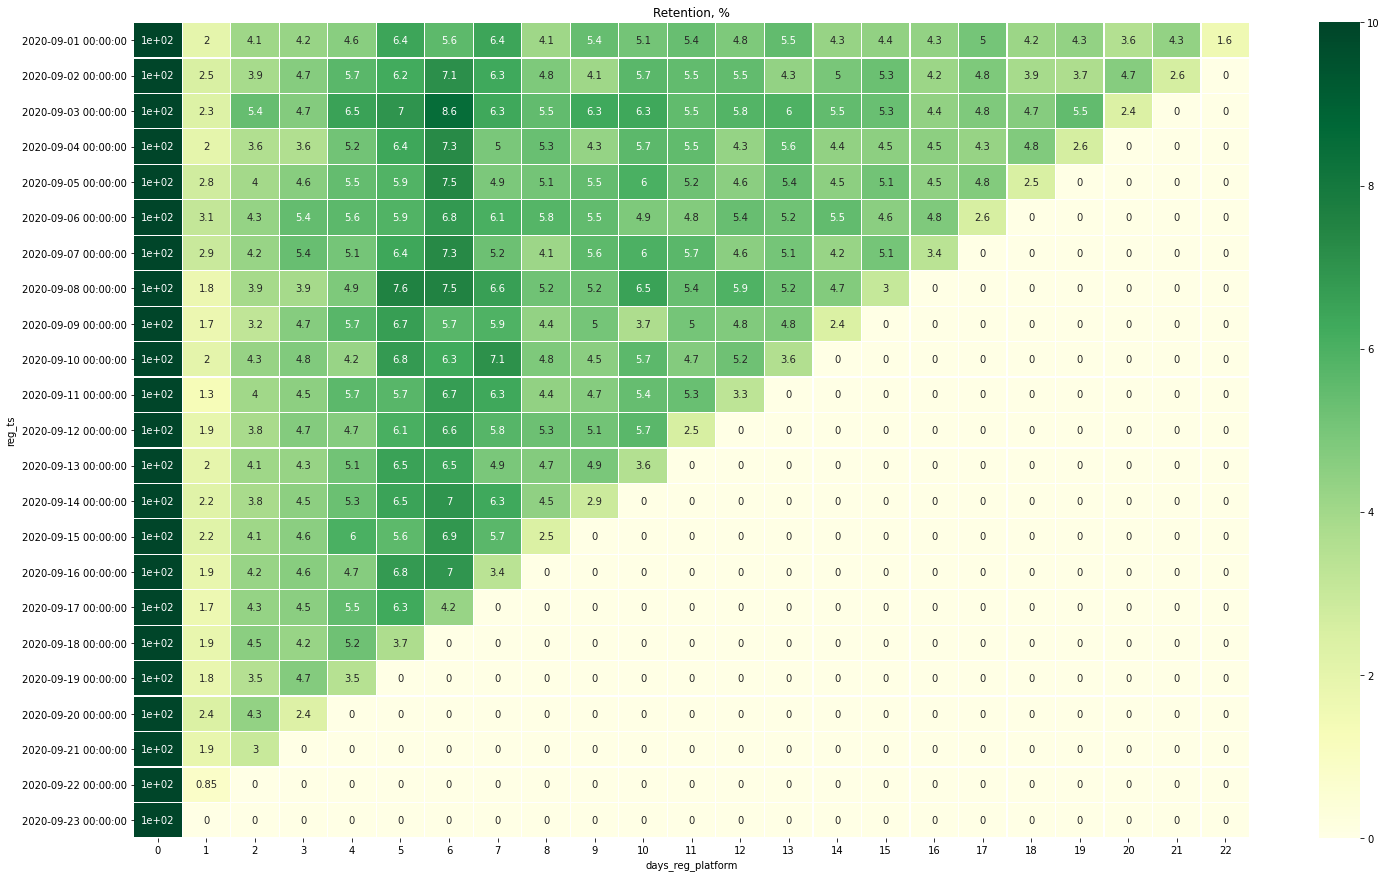

In [38]:
retention(reg_data, auth_data)

## <span style="color:#668B8B"> Задание 2</span> 
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

## <span style="color:#36648B">Произведем подгрузку данных с яндекс диска в датафрейм</span>

In [39]:
def donload_csv(links):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' #Получаем api
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=links))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [40]:
a='https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'


## <span style="color:#36648B">Посмотрим на данные из таблиц (тип данных, колличество записей и т.д.)</span>

In [41]:
offer= pd.read_csv(donload_csv(a), sep=';')

In [42]:
offer.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [43]:
offer.shape

(404770, 3)

In [44]:
offer.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [45]:
offer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [46]:
#посмотрим суммарный доход в тестовой и контрольной группах
rev=offer.groupby('testgroup', as_index=False).agg({'revenue':'sum'})
rev

,testgroup,revenue
0,a,5136189
1,b,5421603


In [47]:
#посмотрим средний чек в тестовой и контрольной группах
mean_chek=round(offer.groupby('testgroup', as_index=False).agg({'revenue':'mean'}).rename(columns={'revenue':'mean_chek'}), 2)
mean_chek

,testgroup,mean_chek
0,a,25.41
1,b,26.75


In [48]:
#Посчитаем колличество пользователей в группах
total=offer.groupby('testgroup', as_index=False).agg({'user_id':'count'}).rename(columns={'user_id':'total_users'})
total

,testgroup,total_users
0,a,202103
1,b,202667


In [49]:
offer.query('revenue>0')

,user_id,revenue,testgroup
72,73,351,a
160,161,3797,b
341,342,290,a
377,378,3768,b
385,386,250,a
...,...,...,...
404315,404316,262,a
404525,404526,3120,b
404543,404544,369,a
404602,404603,251,a


In [50]:
#посмотрим тех пользователейкоторые совершили покупку
paying=offer.query('revenue>0').groupby('testgroup', as_index=False).agg({'user_id':'count'}).\
                                                    rename(columns={'user_id':'paying_users'})
paying

,testgroup,paying_users
0,a,1928
1,b,1805


In [51]:
offer.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [52]:
#соберем ДФ врейм для анализа
itog=rev.merge(mean_chek, on='testgroup').merge(total, on='testgroup').merge(paying, on='testgroup')

In [53]:
itog

,testgroup,revenue,mean_chek,total_users,paying_users
0,a,5136189,25.41,202103,1928
1,b,5421603,26.75,202667,1805


## <span style="color:#36648B">Посчитаем метрики CR, ARPU, ARPPU</span>

In [54]:
itog['not_paying_users']=itog.total_users-itog.paying_users

In [55]:
itog['cr']=round(itog.paying_users/itog.total_users*100,2)

In [56]:
itog['cr']=itog.cr.apply( lambda x : str(x) + '%')

In [57]:
itog

,testgroup,revenue,mean_chek,total_users,paying_users,not_paying_users,cr
0,a,5136189,25.41,202103,1928,200175,0.95%
1,b,5421603,26.75,202667,1805,200862,0.89%


In [58]:
itog['arpu ']=round(itog.revenue/itog.total_users,2)

In [59]:
itog

,testgroup,revenue,mean_chek,total_users,paying_users,not_paying_users,cr,arpu
0,a,5136189,25.41,202103,1928,200175,0.95%,25.41
1,b,5421603,26.75,202667,1805,200862,0.89%,26.75


In [60]:
itog['arppu ']=round(itog.revenue/itog.paying_users,2)

In [61]:
itog

,testgroup,revenue,mean_chek,total_users,paying_users,not_paying_users,cr,arpu,arppu
0,a,5136189,25.41,202103,1928,200175,0.95%,25.41,2664.00
1,b,5421603,26.75,202667,1805,200862,0.89%,26.75,3003.66


In [62]:
# Посмотрим на распределение данных на графиках

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


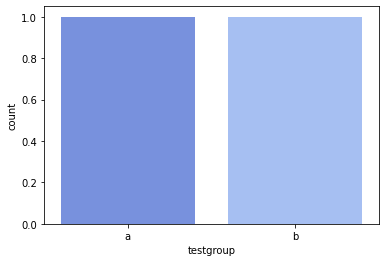

In [63]:
sns.set_palette("coolwarm")
sns.countplot(itog.testgroup)

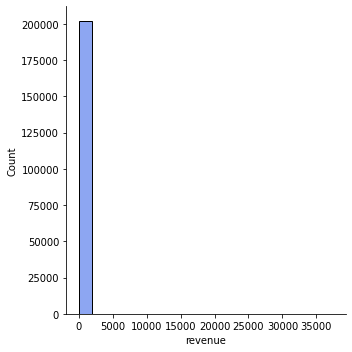

In [64]:
sns.set_palette("coolwarm")
sns.displot(offer[offer.testgroup=='a'].revenue, kde=False)

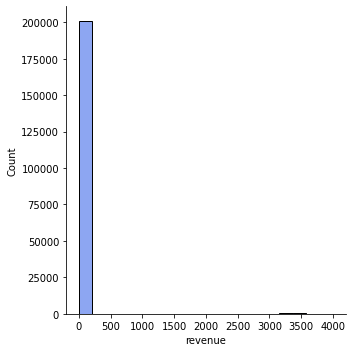

In [65]:
sns.set_palette("coolwarm")
sns.displot(offer[offer.testgroup=='b'].revenue, kde=False)

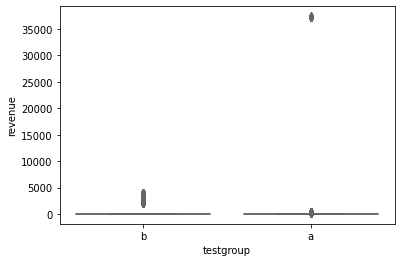

In [66]:
sns.set_palette("coolwarm")
sns.boxplot(x="testgroup", y="revenue", data=offer)

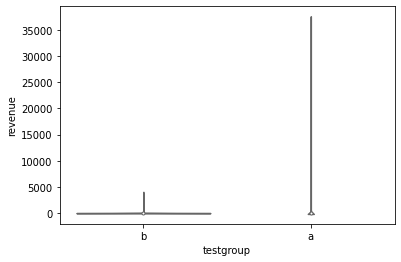

In [67]:
sns.set_palette("coolwarm")
sns.violinplot(x = 'testgroup', y = 'revenue', data = offer)

In [68]:
offer.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [69]:
offer.query("revenue>0 and testgroup in('a')")

,user_id,revenue,testgroup
72,73,351,a
341,342,290,a
385,386,250,a
416,417,37324,a
712,713,255,a
...,...,...,...
404304,404305,360,a
404315,404316,262,a
404543,404544,369,a
404602,404603,251,a


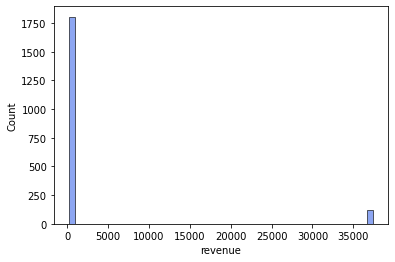

In [70]:
 sns.histplot(data=offer.query("revenue>0 and testgroup in('a')"), x="revenue", bins=50)

In [71]:
#Проведем тест на нормальность распределения

In [72]:
ss.normaltest(offer.query("revenue>0 and testgroup in('a')").revenue)

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)

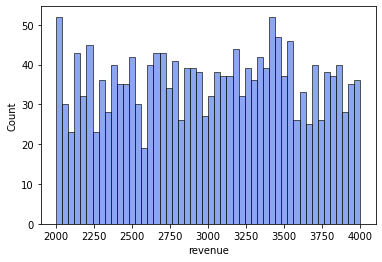

In [73]:
 sns.histplot(data=offer.query("revenue>0 and testgroup in('b')"), x="revenue", bins=50)

In [74]:
ss.normaltest(offer.query("revenue>0 and testgroup in('b')").revenue)

NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)

In [75]:
# Сделаем тесты bootstrap для ARPU и ARPРU, chi2 для CR т.к. распределение не нормальное

In [76]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('#B22222')
        else: 
            bar.set_facecolor('#B0C4DE')
            bar.set_edgecolor('black')
    #'grey'red
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [ ]:
bootstrap_ARPU=get_bootstrap(offer[offer.testgroup=='a'].revenue, offer[offer.testgroup=='b'].revenue)

In [ ]:
bootstrap_ARPU["p_value"]

In [ ]:
bootstrap_ARPU["quants"]

In [ ]:
bootstrap_ARPPU=get_bootstrap(offer.query('revenue>0')[offer.testgroup=='a']\
                            .revenue, offer.query('revenue>0')[offer.testgroup=='b'].revenue)

In [ ]:
bootstrap_ARPPU["p_value"]

In [ ]:
bootstrap_ARPPU["quants"]

In [ ]:
hi_CR=itog[['paying_users','not_paying_users']]

In [ ]:
p_value=chi2_contingency(hi_CR,correction=True)[1]
print("p-value:", p_value)

#### <span style="color:#668B8B"> Вывод: для нулевой гипотезы берем отсутствие стат значимости различий между контрольной и тестовой группа. Для альтернативной гипотезы есть стат значимые различия. В итоге мы получили статистически значимые различия между двумя группами в ARPPU и ARPU, хотя при  chi2 различия не стат значимы CR. Тем не менее, по результатам проведенных тестов с высокой долей вероятности мы можем утверждать, что тестовое акционное предложение лучше контрольного, и оно приносит компании больший доход. Так же есть выбросы которые требуется детально изучить.</span> 